In [1]:
import imageio
import glob
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
np.random.seed(6666) # to reprodece the performance, you can also remove it

### Dataloader

In [2]:
data = np.zeros(shape=(490*3, 32, 32, 4))
label = np.zeros(shape=(490*3, 3)) # one hot 
for i, im_path in enumerate(glob.glob("./Data/Data_train/Carambula/*.png")):
    im = imageio.imread(im_path)
    data[i] = np.array(im)
    label[i] = np.array([1, 0, 0]) # one hot
for i, im_path in enumerate(glob.glob("./Data/Data_train/Lychee/*.png")):
    im = imageio.imread(im_path)
    data[490+i] = np.array(im)
    label[490+i] = np.array([0, 1, 0]) # one hot
for i, im_path in enumerate(glob.glob("./Data/Data_train/Pear/*.png")):
    im = imageio.imread(im_path)
    data[490*2+i] = np.array(im)
    label[490*2+i] = np.array([0, 0, 1])
d = data.flatten().reshape(490*3, 4096) # flatten & reshape the data array

In [3]:
test_data = np.zeros(shape=(166*3, 32, 32, 4))
test_label = np.zeros(shape=(166*3, 3)) # one hot 
for i, im_path in enumerate(glob.glob("./Data/Data_test/Carambula/*.png")):
    im = imageio.imread(im_path)
    test_data[i] = np.array(im)
    test_label[i] = np.array([1, 0, 0]) # one hot
for i, im_path in enumerate(glob.glob("./Data/Data_test/Lychee/*.png")):
    im = imageio.imread(im_path)
    test_data[166+i] = np.array(im)
    test_label[166+i] = np.array([0, 1, 0]) # one hot
for i, im_path in enumerate(glob.glob("./Data/Data_test/Pear/*.png")):
    im = imageio.imread(im_path)
    test_data[166*2+i] = np.array(im)
    test_label[166*2+i] = np.array([0, 0, 1])
test_d = test_data.flatten().reshape(166*3, 4096) # flatten & reshape the data array

# Part (a)
## 1. PCA

### Standardize the Data
Normalize the input data, since PCA is effected by scale

In [4]:
scaler = StandardScaler()
# Fit on training set only.
scaler.fit(d)
# Apply transform to both the training set and the test set.

train_img = scaler.transform(d)
test_img = scaler.transform(test_d)

### Apply PCA on training & testing data
1. Set the components of PCA as 2
2. fitting PCA on training data set
3. apply the pca to training & testing data

In [5]:
pca = PCA(n_components=2)

pca.fit(train_img)

train_img = pca.transform(train_img)
test_img = pca.transform(test_img)

## 2. Two layer NN
### The implement detals are listed below:
1. The neural network was modulized as a class with several funcion belows
2. In `init()` the var `self.const` was set to prevent from dividing zero to cause INF value, and the `self.step` is the gradient step. The hidden_d assign the hidden dimension of the network
3. `sigmoid()` and `softmax()` are the activate functoins
4. `sigmoid_derivative` is the derivative of sigmoid activate functoin
5. `softmax_cross_entropy_deriative()` is the product between derivative of softmax & derivative of cross entropy loss
6. `batch_norm()` is implementation of batch normalization, to prevent sigmoid to satiate easily
7. `forward()` forward the input throughout the network, used when testing time
8. `backprop()` is used when training time, including the the forward pass of the network and calculating the gradient with back-propagation by chain rules

### The pipeline
input_date --> concate bias_0 -->weights1 --> Z1 --> sigmoid --> output of layer1 --> add bias_1 --> weights2 --> Z2 --> softmax --> output

### Stochastic gradient descent (SGD)
The center concept of SGD differet from gradient descent is that SGD using mini-batch, not whole training dataset, to calculate the loss then optimize.
The implimentation of SGD in this assignment is that I random sample a batch of input data from training set in `train()` function, the input parameter `batch_size` determine the mini-batch size.

In [6]:
class twoLayerNN():
    
    def __init__(self, input_shape, output_shape, hidden_d=32):
        # seeding for random number generation
        np.random.seed(1)
        self.weights1   = np.random.rand(input_shape+1,hidden_d) # +1 is the bias 
        self.weights2   = np.random.rand(hidden_d,output_shape)
        self.b_std = np.zeros(shape=(hidden_d,))
        self.b_mean = np.zeros(shape=(hidden_d,))
        self.bias_1 = np.random.rand(1, hidden_d) # hidden layer1 bias (from [0.1))
        self.const = 0.00000000001 # prevent from / 0
        self.step = 0.1

    def weights(self): # testing for debug
        return self.weights1, self.weights2
    
    def sigmoid(self, x):
        #applying the sigmoid function
        return 1 / (1 + np.exp(-x))
    
    def sigmoid_derivative(self, x):
        #computing derivative to the Sigmoid function
        return x * (1 - x)
    
    def softmax(self, x):
        exps = np.exp(x - np.max(x, axis=1).reshape(x.shape[0], 1))
        return exps / np.sum(exps, axis=1).reshape(x.shape[0], 1)
    
    def batch_norm(self, x, bigBatch=True):
        if bigBatch: # training time
            m = np.mean(x, axis=0)
            s = np.std(x, axis=0)
        else: # testing time
            m = self.b_mean
            s = self.b_std
        return (x-m)/(s+self.const), m, s
    
    def batch_norm_derivative(self, x):
        return (np.std(x, axis=0) + self.const)**(-1)
    
    def softmax_cross_entropy_deriative(self, x, y):
        return (x - y) # see how cross entropy loss & softmax deriative 
    
    def cross_entropy(self, x, y):
        return -np.log(x+self.const)*y
    
    def forward(self, x):
        bias_0 = np.random.randn(x.shape[0], 1) # input bais
        x = np.concatenate((bias_0, x), axis=1) # concatenate the bias to the input
        z1 = np.dot(x, self.weights1)
        batch_norm1, _, _ = self.batch_norm(z1, bigBatch=False)
        layer1 = self.sigmoid(batch_norm1)
        bias_1 = self.bias_1 # hidden layer1 bias (from [0.1))
        layer1 += bias_1
        z2 = np.dot(layer1, self.weights2)
        out = self.softmax(z2)
        return out, z1, z2
    
    def backprop(self, x, y, iteration):
        bias_0 = np.random.randn(x.shape[0], 1) # input bais
        x = np.concatenate((bias_0, x), axis=1) # concatenate the bias to the input
        
        z1 = np.dot(x, self.weights1)
        batch_norm1, mean, std = self.batch_norm(z1)
        if not iteration == 0:
            self.b_mean = 0.9*self.b_mean + 0.1*mean
            self.b_std = 0.9*self.b_std + 0.1*std
        else:
            self.b_mean = mean
            self.b_std = std
        layer1 = self.sigmoid(batch_norm1)
        bias_1 = self.bias_1 # hidden layer1 bias (from [0.1))
        layer1_b = layer1+bias_1 # WX+b
        z2 = np.dot(layer1_b, self.weights2)
        out = self.softmax(z2)
        
        ## backprop & calculate the gradient
        
        d_softmax_cross = self.softmax_cross_entropy_deriative(out, y)/y.shape[0] # mean
        d_weights2 = np.dot(np.transpose(layer1_b), d_softmax_cross)
        b = np.dot(d_softmax_cross, np.transpose(self.weights2)) \
        * self.sigmoid_derivative(layer1) * self.batch_norm_derivative(z1)

        d_weights1 = np.dot(np.transpose(x),  b)
        d_bias1 = np.dot(np.ones(shape=(1, x.shape[0])), b)

        ## update weights
        self.weights2 -= self.step*d_weights2
        self.weights1 -= self.step*d_weights1
        self.bias_1 -= self.step*d_bias1
        
        loss = self.cross_entropy(out, y)
        loss = np.sum(loss, axis=1)
        loss = np.mean(loss)
        accuracy = self.accuracy(out, y)
        return loss, accuracy
    
    def train(self, data, label ,total_iteration, batch_size=128, log=True):
        for i in range(total_iteration):
            idx = np.random.choice(490*3, batch_size, replace=False) # sample a batch of training data
            loss, accuracy = self.backprop(data[idx], label[idx], i)
            if i%1000 == 0 and log is True:
                print("iteration %d: cross entrpy loss is %f, accuracy is %f" %(i, loss, accuracy))
        return loss
    def test(self, data, label, log=False):
        batch_size = data.shape[0]
        out, _, _ = self.forward(data)
        if data.shape[0] > 10: # if input test size is not too big, show the prediction
            accuracy = self.accuracy(out, label, log=log)
            print("testing size : %d, accuracy: %f" %(batch_size, accuracy))
        else:                  # otherwise, show the accuracy only
            prediction = np.argmax(out, axis=1)[0]
            ground_truth = np.argmax(label, axis=1)[0]
            print("prediction is : %d, ground truth is: %d" %(prediction, ground_truth))

    def accuracy(self, x, y, log=False):
        prediction = np.argmax(x, axis=1)
       
        ground_truth = np.argmax(y, axis=1)
        comparison = (prediction == ground_truth)
        r = np.sum(comparison) # count the number of correct  answer(true)
        if log:
            print(prediction)
            print(r)
        accuracy = r / y.shape[0] #accuracy
        return accuracy


## 3. performance & discussion
### (i) training performance
Train a 2 layer NN with hidden dim = 32 <br>
batch size = 128 <br>
iteration: 100000 <br>
The output include cross entropy & accuarcy for every 1000 iterations

In [7]:
nn = twoLayerNN(train_img.shape[1], 3, hidden_d=32)
_ = nn.train(train_img, label, 10000)

iteration 0: cross entrpy loss is 1.113041, accuracy is 0.335938
iteration 1000: cross entrpy loss is 0.418622, accuracy is 0.859375
iteration 2000: cross entrpy loss is 0.433221, accuracy is 0.843750
iteration 3000: cross entrpy loss is 0.469763, accuracy is 0.804688
iteration 4000: cross entrpy loss is 0.370516, accuracy is 0.867188
iteration 5000: cross entrpy loss is 0.492652, accuracy is 0.765625
iteration 6000: cross entrpy loss is 0.425867, accuracy is 0.851562
iteration 7000: cross entrpy loss is 0.371173, accuracy is 0.851562
iteration 8000: cross entrpy loss is 0.367706, accuracy is 0.859375
iteration 9000: cross entrpy loss is 0.338250, accuracy is 0.898438


### (ii) Testing performance
The output include Testing size & accuarcy

In [8]:
nn.test(test_img, test_label, log=False)

testing size : 498, accuracy: 0.943775


### (iii) Decision region
The function below display the k-NN decsion boundaries for the neuron of last layer before softmax
The implement details as below:
1. extract the neuron of last layer before softmax
2. Use PCA to downgrade into 2d
3. Use 15 neighbors' label to decide the mesh color (K-NN algo form `sklearn`)
4. the `layer` parameters indicate the total numbers of layer of the NN (since I share the same function between 2-layer NN and 3-layer NN)

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors
%matplotlib inline
def plot_decision_boundary(x, nn, layer=3):

    n_neighbors = 15
    h = .02  # step size in the mesh
    nn = nn
    
    # Create color maps
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])

    weights = 'uniform'
        # we create an instance of Neighbours Classifier and fit the data.
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
    if layer == 2:
        out, _, z2 = nn.forward(x)
        X = z2
    else:
        out, _, _, z3 = nn.forward(x)
        X = z3
    scaler = StandardScaler()
    scaler.fit(X)
    X = scaler.transform(X)
    pca = PCA(n_components=2)
    pca.fit(X)
    X = pca.transform(X)
    prediction = np.argmax(out, axis=1)
    y = prediction
    clf.fit(X, y)
    
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
#     plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, label=['1', '2', '3'])
    markers=['s', 'x', 'o']
    labels=[0, 1, 2]
    names = ['Carambula', 'Lychee', 'Pear']
    for c, i, target_name, m in zip('rgb', labels, names, markers):
        plt.scatter(X[y==i, 0], X[y==i, 1], c=c, label=target_name, marker=m)
    plt.xlabel('PCA-feature-1')
    plt.ylabel('PCA-feature-2')
    plt.legend(loc='upper right')
#     plt.legend(loc='upper right')

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("decision regions of layer %d (k = %i, weights = '%s')" % (layer, n_neighbors, weights))
    plt.show()


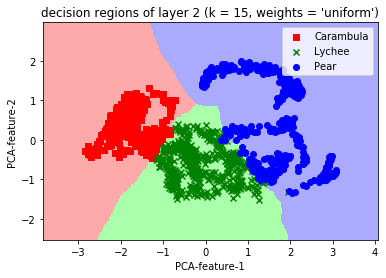

In [10]:
plot_decision_boundary(train_img, nn, layer=2)

##### ↑ looks good! :) 

### (iiii) Discssion
#### Training loss with different hyperparameters
Test the hidden dimension from 16 - 1024 with log scale with base 2 and plot the croos entropy loss with 5000 iterations

In [11]:
losses = []
for i in range(4, 11):
    n = 2**i
    nn = twoLayerNN(train_img.shape[1], 3, hidden_d=n)
    loss = nn.train(train_img, label, 5000, log=False)
    losses.append(loss)

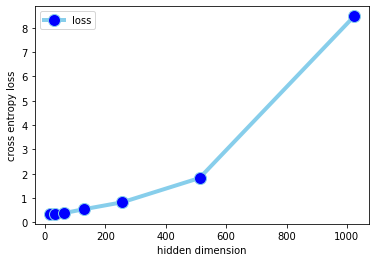

In [12]:
import pandas as pd
dff=pd.DataFrame({'x': [16, 32, 64, 128, 256, 512, 1024], 'loss': losses})
 
plt.xlabel('hidden dimension')
plt.ylabel('cross entropy loss')
plt.plot( 'x', 'loss', data=dff, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
# plt.plot( 'x', 'Testing Set', data=dff, marker='x', color='olive', linewidth=2)
plt.legend()
plt.show()

We can see that in such simple case, the network with too large dimension might not have good performance compare to the smaller one

# Part. (b)
## 1. Three layer NN
### The implement detals are listed below:
1. The neural network was modulized as a class with several funcion belows
2. In `init()` the var `self.const` was set to prevent from dividing zero to cause INF value, and the `self.step` is the gradient step. The hidden_d assign the hidden dimension of the network
3. `sigmoid()` and `softmax()` are the activate functoins
4. `sigmoid_derivative` is the derivative of sigmoid activate functoin
5. `softmax_cross_entropy_deriative()` is the product between derivative of softmax & derivative of cross entropy loss
6. `batch_norm()` is implementation of batch normalization, to prevent sigmoid to satiate easily
7. `forward()` forward the input throughout the network, used when testing time
8. `backprop()` is used when training time, including the the forward pass of the network and calculating the gradient with back-propagation by chain rules

### The pipeline
input_date --> concate bias_0 -->weights1 --> Z1 --> sigmoid --> output of layer1 --> add bias_1 --> weights2 --> Z2 --> sigmoid --> output of layer2 --> add bias_2 --> weights3 --> Z3--> softmax --> output

### Stochastic gradient descent (SGD)
The center concept of SGD differet from gradient descent is that SGD using mini-batch, not whole training dataset, to calculate the loss then optimize.
The implimentation of SGD in this assignment is that I random sample a batch of input data from training set in `train()` function, the input parameter `batch_size` determine the mini-batch size.

In [13]:
class threeLayerNN():
    
    def __init__(self, input_shape, output_shape, hidden_d=32):
        # seeding for random number generation
        np.random.seed(1)
        self.weights1 = np.random.rand(input_shape+1,hidden_d) # +1 is the bias 
        self.weights2 = np.random.rand(hidden_d,hidden_d)
        self.weights3 = np.random.rand(hidden_d,output_shape)
        self.b_std = np.zeros(shape=(hidden_d,))
        self.b_mean = np.zeros(shape=(hidden_d,))
        self.b_std_1 = np.zeros(shape=(hidden_d,))
        self.b_mean_1 = np.zeros(shape=(hidden_d,))
        self.bias_1 = np.random.rand(1, hidden_d) # hidden layer1 bias (from [0.1))
        self.bias_2 = np.random.rand(1, hidden_d) # hidden layer2 bias (from [0.1))
        self.const = 0.00000000001 # prevent from / 0
        self.step = 0.1

    def weights(self):
        return self.weights1, self.weights2
    
    def sigmoid(self, x):
        #applying the sigmoid function
        return 1 / (1 + np.exp(-x))
    
    def sigmoid_derivative(self, x):
        #computing derivative to the Sigmoid function
        return x * (1 - x)
    
    def softmax(self, x):
        exps = np.exp(x - np.max(x, axis=1).reshape(x.shape[0], 1))
        return exps / np.sum(exps, axis=1).reshape(x.shape[0], 1)
    
    def batch_norm(self, x, bigBatch=True, second=False):
        if bigBatch:
            m = np.mean(x, axis=0)
            s = np.std(x, axis=0)
        else:
            if second is True: # 2nd layer batch norm
                m = self.b_mean_1
                s = self.b_std_1
            else:
                m = self.b_mean
                s = self.b_std
        return (x-m)/(s+self.const), m, s
    
    def batch_norm_derivative(self, x):
        return (np.std(x, axis=0) + self.const)**(-1)
    
    def softmax_cross_entropy_deriative(self, x, y):
        return (x - y) # see how cross entropy loss & softmax deriative 
    
    def cross_entropy(self, x, y):
        return -np.log(x+self.const)*y
    
    def forward(self, x):
        bias_0 = np.random.randn(x.shape[0], 1) # input bais
        x = np.concatenate((bias_0, x), axis=1) # concatenate the bias to the input
        z1 = np.dot(x, self.weights1)
        batch_norm1, _, _ = self.batch_norm(z1, bigBatch=False)
        layer1 = self.sigmoid(batch_norm1)
        bias_1 = self.bias_1 # hidden layer1 bias (from [0.1))
        layer1 += bias_1
        z2 = np.dot(layer1, self.weights2)
        batch_norm2, _, _ = self.batch_norm(z2, bigBatch=False, second=True)
        layer2 = self.sigmoid(batch_norm2)
        bias_2 = self.bias_2 # hidden layer1 bias (from [0.1))
        layer2 += bias_2
        z3 = np.dot(layer2, self.weights3)
        out = self.softmax(z3)
        return out, z1, z2, z3
    
    def backprop(self, x, y, iteration):
        bias_0 = np.random.randn(x.shape[0], 1) # input bais
        x = np.concatenate((bias_0, x), axis=1) # concatenate the bias to the input
        
        z1 = np.dot(x, self.weights1)
        batch_norm1, mean, std = self.batch_norm(z1)
#         print(mean.shape)
        if not iteration == 0:
            self.b_mean = 0.9*self.b_mean + 0.1*mean
            self.b_std = 0.9*self.b_std + 0.1*std
        else:
            self.b_mean = mean
            self.b_std = std
        layer1 = self.sigmoid(batch_norm1)
        
        bias_1 = self.bias_1 # hidden layer1 bias (from [0.1))
        layer1_b = layer1+bias_1 # WX+b
        z2 = np.dot(layer1_b, self.weights2)
        batch_norm2, mean, std = self.batch_norm(z2, second=True)
        if not iteration == 0:
            self.b_mean_1 = 0.9*self.b_mean_1 + 0.1*mean
            self.b_std_1 = 0.9*self.b_std_1 + 0.1*std
        else:
            self.b_mean = mean
            self.b_std = std
        layer2 = self.sigmoid(batch_norm2)
        
        bais_2 = self.bias_2
        layer2_b = layer2 + bais_2
        z3 = np.dot(layer2_b, self.weights3)
        out = self.softmax(z3)
        
#         print(layer1)
        ## backprop & calculate the gradient
        
        d_softmax_cross = self.softmax_cross_entropy_deriative(out, y)/y.shape[0] # mean
        d_weights3 = np.dot(np.transpose(layer2_b), d_softmax_cross)
        
        b0 = np.dot(d_softmax_cross, np.transpose(self.weights3)) \
        * self.sigmoid_derivative(layer2) * self.batch_norm_derivative(z2)
        d_weights2 = np.dot(np.transpose(layer1_b), b0)
        d_bias2 = np.dot(np.ones(shape=(1, layer1_b.shape[0])), b0) 
        
        b = np.dot(b0, np.transpose(self.weights2)) \
        * self.sigmoid_derivative(layer1) * self.batch_norm_derivative(z1)
        d_weights1 = np.dot(np.transpose(x),  b)
        d_bias1 = np.dot(np.ones(shape=(1, x.shape[0])), b)
        
        ## update weights
        self.weights3 -= self.step*d_weights3
        self.weights2 -= self.step*d_weights2
        self.weights1 -= self.step*d_weights1
        self.bias_2 -= self.step*d_bias2
        self.bias_1 -= self.step*d_bias1 
#         print(d_weights1)
        
        loss = self.cross_entropy(out, y)
        loss = np.sum(loss, axis=1)
        loss = np.mean(loss)
        accuracy = self.accuracy(out, y)
        return loss, accuracy
    
    def train(self, data, label ,total_iteration, batch_size=128, log=True):
        for i in range(total_iteration):
            idx = np.random.choice(490*3, batch_size, replace=False)
            loss, accuracy = self.backprop(data[idx], label[idx], i)
            if i%1000 == 0 and log is True:
                print("iteration %d: cross entrpy loss is %f, accuracy is %f" %(i, loss, accuracy))
        return loss
    def test(self, data, label, log=False):
        batch_size = data.shape[0]
        out, _, _, _ = self.forward(data)
        if data.shape[0] > 10: # if input test size is not too big, show the prediction
            accuracy = self.accuracy(out, label, log=log)
            print("testing size : %d, accuracy: %f" %(batch_size, accuracy))
        else:                  # otherwise, show the accuracy only
            prediction = np.argmax(out, axis=1)[0]
            ground_truth = np.argmax(label, axis=1)[0]
            print("prediction is : %d, ground truth is: %d" %(prediction, ground_truth))

    def accuracy(self, x, y, log=False):
        prediction = np.argmax(x, axis=1)
       
        ground_truth = np.argmax(y, axis=1)
        comparison = (prediction == ground_truth)
        r = np.sum(comparison) # count the number of correct  answer(true)
        if log:
            print(prediction)
            print(r)
        accuracy = r / y.shape[0] #accuracy
        return accuracy
    

## 3. performance & discussion
### (i) training performance
Train a 2 layer NN with hidden dim = 32 <br>
batch size = 128 <br>
iteration: 100000 <br>
The output include cross entropy & accuarcy for every 1000 iterations

In [14]:
nn3 = threeLayerNN(train_img.shape[1], 3, hidden_d=32)
_ = nn3.train(train_img, label, 10000)

iteration 0: cross entrpy loss is 1.524063, accuracy is 0.359375
iteration 1000: cross entrpy loss is 0.596580, accuracy is 0.804688
iteration 2000: cross entrpy loss is 0.416016, accuracy is 0.890625
iteration 3000: cross entrpy loss is 0.423091, accuracy is 0.828125
iteration 4000: cross entrpy loss is 0.460228, accuracy is 0.781250
iteration 5000: cross entrpy loss is 0.396366, accuracy is 0.859375
iteration 6000: cross entrpy loss is 0.506677, accuracy is 0.789062
iteration 7000: cross entrpy loss is 0.411173, accuracy is 0.859375
iteration 8000: cross entrpy loss is 0.272968, accuracy is 0.921875
iteration 9000: cross entrpy loss is 0.437793, accuracy is 0.835938


### (ii) Testing performance
The output include Testing size & accuarcy

In [15]:
nn3.test(test_img, test_label, log=False)

testing size : 498, accuracy: 0.937751


### (iii) Decision region
The function is as same as the one above, if you want to know about the details, pls check the discription ablove!

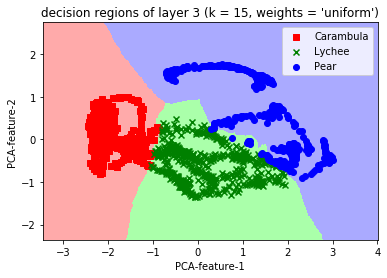

In [16]:
plot_decision_boundary(train_img, nn3, layer=3)

##### ↑ still looks perfect! :) 

### (iiii) Discssion
#### Training loss with different hyperparameters
Test the hidden dimension from 16 - 1024 with log scale with base 2 and plot the croos entropy loss with 5000 iterations

In [17]:
losses = []
for i in range(4, 11):
    n = 2**i
    nn3 = threeLayerNN(train_img.shape[1], 3, hidden_d=n)
    loss = nn3.train(train_img, label, 5000, log=False)
    losses.append(loss)

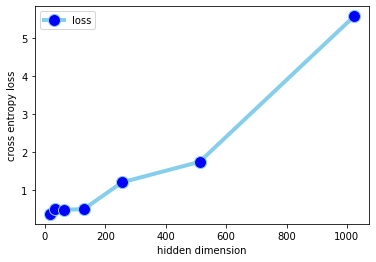

In [18]:
import pandas as pd
dff=pd.DataFrame({'x': [16, 32, 64, 128, 256, 512, 1024], 'loss': losses})
 
plt.xlabel('hidden dimension')
plt.ylabel('cross entropy loss')
plt.plot( 'x', 'loss', data=dff, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
# plt.plot( 'x', 'Testing Set', data=dff, marker='x', color='olive', linewidth=2)
plt.legend()
plt.show()

Still, we can see that in such simple case, the network with too large dimension might not have good performance compare to the smaller one